# CIFAR10 Classification

### HW2 @ DL Course, Dr. Soleymani

*Full Name:* Seyed Amir Kasaei

*SID:* 402212214

contribution with amir mohammad ezzati

In this part of the assignment we want to do an image classification task using PyTorch on CIFAR10 dataset.

## Import Libraries

Import needed libraries

In [10]:
import torch
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image, pil_to_tensor
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np

## Device

Set device to work with (GPU or CPU)

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.20, 0.20, 0.20)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.20, 0.20, 0.20)),
])



In [15]:
# inverse the normilize transform to restore the original data
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        # TODO
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

norminv = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.20, 0.20, 0.20))

In [ ]:
initial_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

100%|██████████| 170498071/170498071 [00:01<00:00, 95418718.87it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
trainset, valset = random_split(initial_trainset, [0.8, 0.2])

In [ ]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)

In [ ]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

Files already downloaded and verified


## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

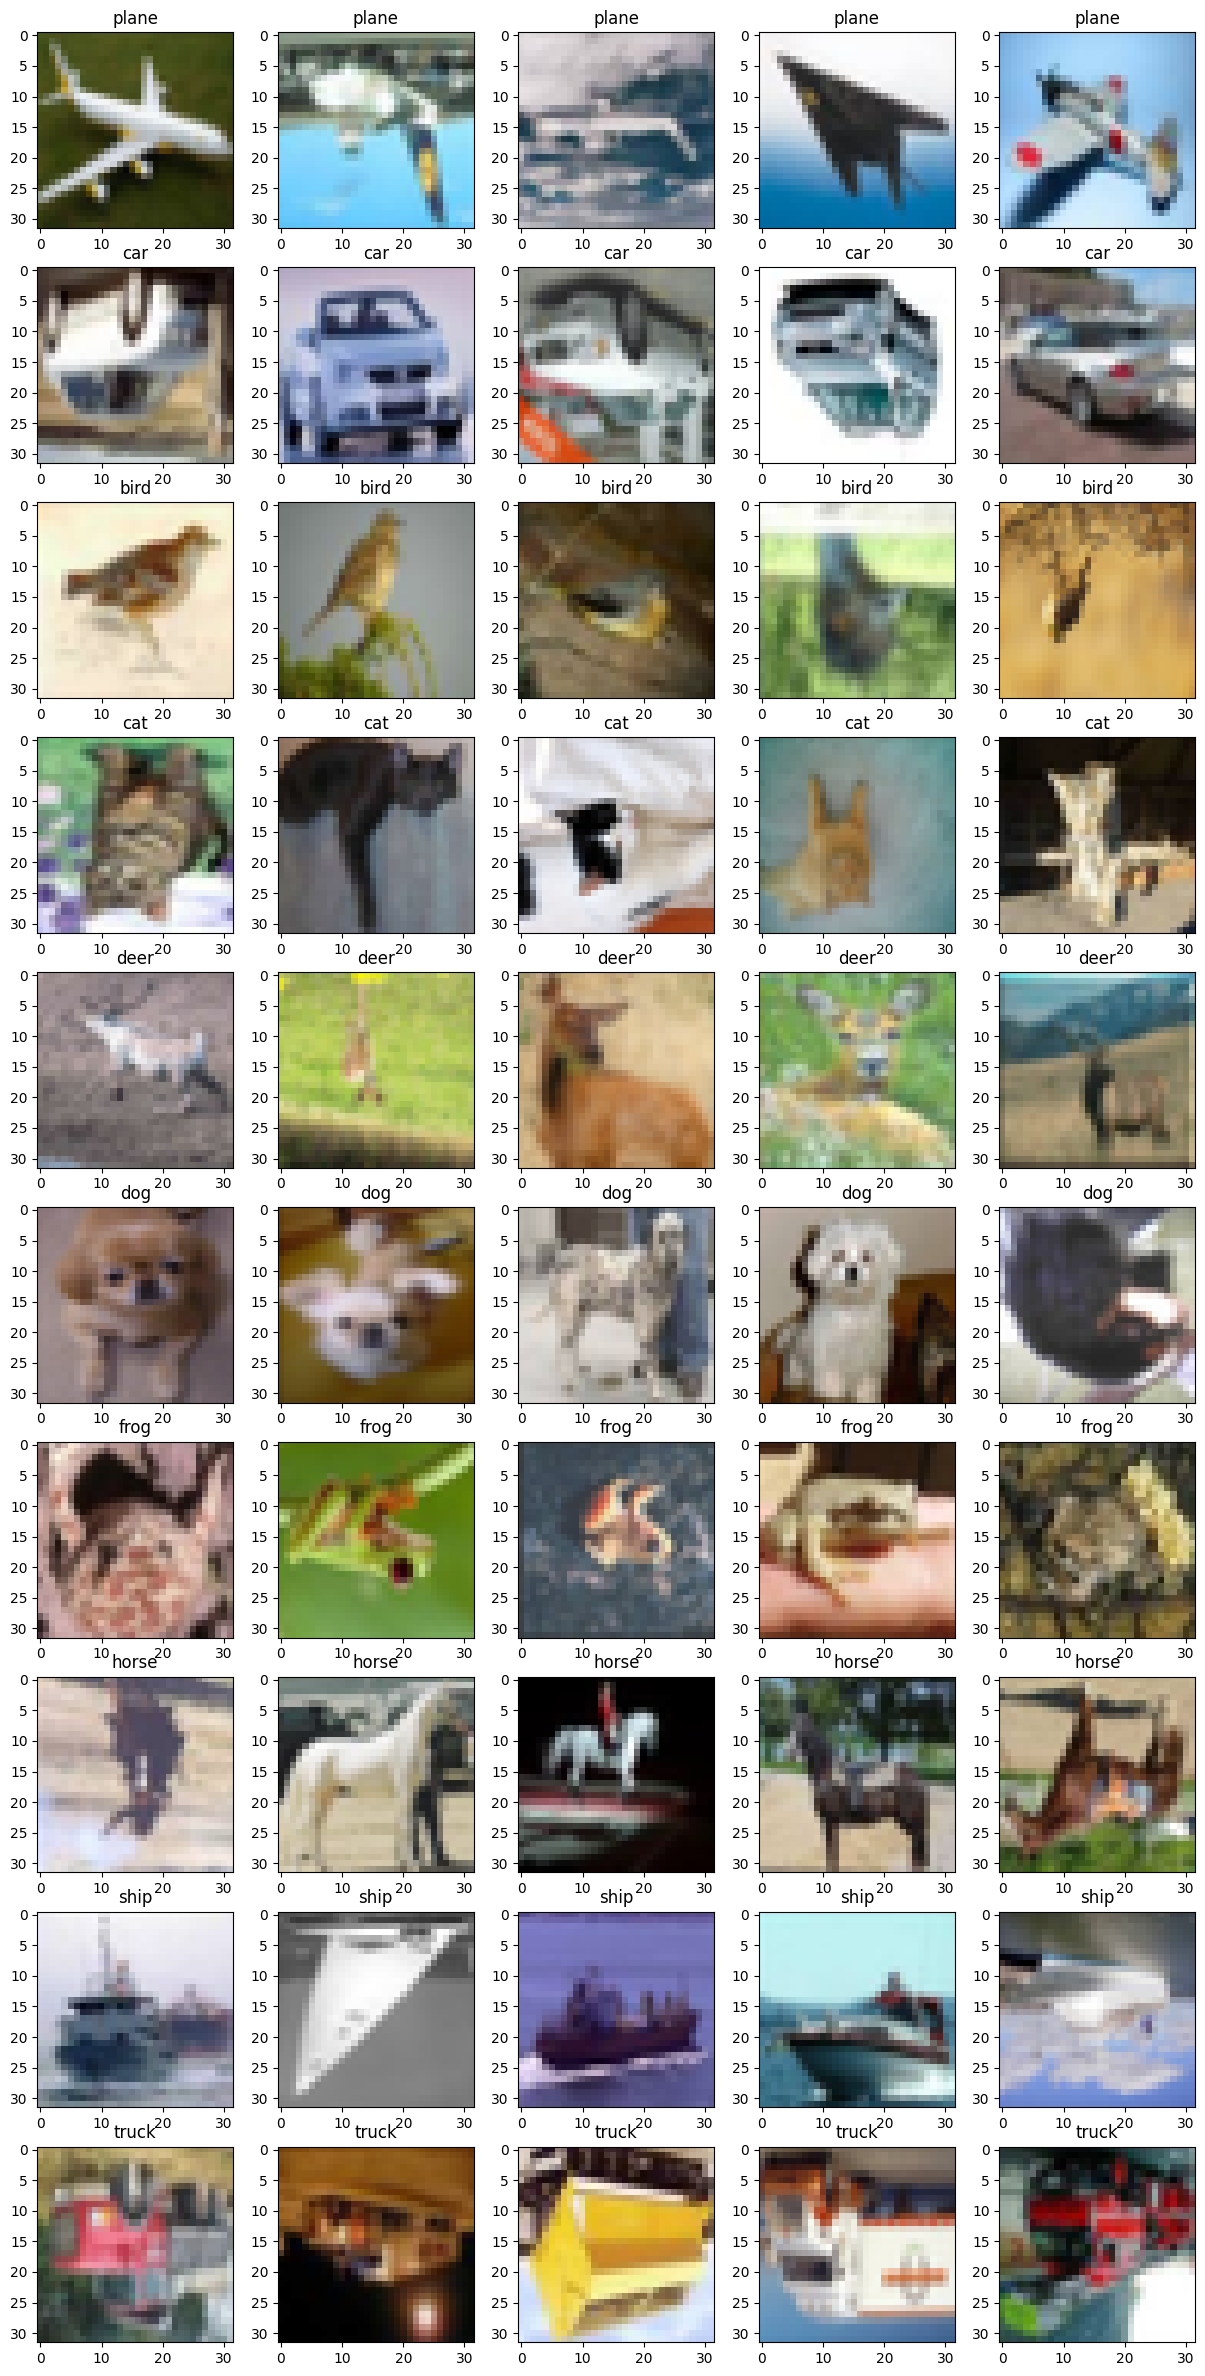

In [ ]:
# TODO
fig,axs = plt.subplots(len(classes),5, figsize=(15,30))
for i in range(len(classes)):
    class_idxs = np.where(np.array(initial_trainset.targets) == i)[0]
    idxs = np.random.choice(class_idxs, 5)
    for j, idx in enumerate(idxs):
      axs[i][j].title.set_text(classes[i])
      axs[i][j].imshow(to_pil_image(norminv(initial_trainset[idx][0])))

## Model

Define your ResNet model here from scratch (You are not allowed to use the existing models in pytorch)

Our suggestion is to implement ResNet18

In [ ]:
class ResNetBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet18(nn.Module):


    def __init__(self, block, layers, num_classes=10):
        super(ResNet18, self).__init__()
        # TODO
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=1, bias=False),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)

        self.avgpool = nn.AvgPool2d(4, stride=1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        # TODO
        x = self.conv1(x)

        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [ ]:
net = ResNet18(ResNetBlock, [2, 2, 2, 2])
net.to(device)

ResNet18(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

### Train loop

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- [ ] save train/validation loss and accuracy (of each epoch) in an array for later usage

In [ ]:
import tqdm
from time import time

In [ ]:
def train_epoch(net: torch.nn.Module, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer,scheduler: torch.optim.lr_scheduler ,dataloader: torch.utils.data.DataLoader):
    net.train() # Set model to training mode

    running_loss = 0.0
    running_accuracy = 0.0

    # Iterate over data.
    for inputs, labels in dataloader:
      inputs = inputs.to(device)
      labels = labels.type(torch.LongTensor).to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward
      with torch.set_grad_enabled(True):
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)


        loss.backward()
        optimizer.step()

      # statistics
      running_loss += loss.item()
      running_accuracy += sklearn.metrics.accuracy_score(labels.cpu(), preds.cpu())

    loss = running_loss / len(dataloader)
    accuracy = running_accuracy / len(dataloader)

    scheduler.step(loss)

    return loss, accuracy

def eval_epoch(net: torch.nn.Module, criterion: torch.nn.Module, dataloader: torch.utils.data.DataLoader, test_mode: bool = False):
    net.eval() # Set model to evaluation mode

    running_loss = 0.0
    running_accuracy = 0.0

    # Iterate over data.
    for inputs, labels in dataloader:
      inputs = inputs.to(device)
      labels = labels.type(torch.LongTensor).to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward
      with torch.set_grad_enabled(False):
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

      # statistics
      running_loss += loss.item()
      running_accuracy += sklearn.metrics.accuracy_score(labels.cpu(), preds.cpu())

    loss = running_loss / len(dataloader)
    accuracy = running_accuracy / len(dataloader)

    return loss, accuracy


In [ ]:
epochs = 20
model_path = '/content/drive/MyDrive/AI/Deep Learning/DL/HW2/resnet18.pt'

best_val_loss = float('inf')
best_val_acc = 0

accuracy_dic, loss_dic = {}, {}
loss_dic['train'], loss_dic['val'] = [], []
accuracy_dic['train'], accuracy_dic['val'] = [], []

for e in range(epochs):
    train_loss, train_acc= train_epoch(net, criterion, optimizer, scheduler, trainloader)
    val_loss, val_acc = eval_epoch(net, criterion, valloader)

    loss_dic['train'].append(train_loss)
    loss_dic['val'].append(val_loss)
    accuracy_dic['train'].append(train_acc)
    accuracy_dic['val'].append(val_acc)

    if val_loss < best_val_loss:
        best_val_acc = val_acc
        best_val_loss = val_loss
        # best_model = model.state_dict()
        torch.save(net.state_dict(), model_path)

    print(f'Epoch [{e+1}/{epochs}] - '
            f'Train Loss: {train_loss:.4f} - '
            f'Train Accuracy: {train_acc:.4f} - '
            f'Validation Loss: {val_loss:.4f} - '
            f'Validation Accuracy {val_acc:.4f}')



Epoch [1/20] - Train Loss: 1.0560 - Train Accuracy: 0.6258 - Validation Loss: 1.0174 - Validation Accuracy 0.6343
Epoch [2/20] - Train Loss: 0.9113 - Train Accuracy: 0.6745 - Validation Loss: 0.9114 - Validation Accuracy 0.6819
Epoch [3/20] - Train Loss: 0.8167 - Train Accuracy: 0.7106 - Validation Loss: 0.8314 - Validation Accuracy 0.7084
Epoch [4/20] - Train Loss: 0.7447 - Train Accuracy: 0.7318 - Validation Loss: 0.7451 - Validation Accuracy 0.7373
Epoch [5/20] - Train Loss: 0.6805 - Train Accuracy: 0.7575 - Validation Loss: 0.7716 - Validation Accuracy 0.7228
Epoch [6/20] - Train Loss: 0.6141 - Train Accuracy: 0.7824 - Validation Loss: 0.6619 - Validation Accuracy 0.7671
Epoch [7/20] - Train Loss: 0.5603 - Train Accuracy: 0.8015 - Validation Loss: 0.6358 - Validation Accuracy 0.7780
Epoch [8/20] - Train Loss: 0.5132 - Train Accuracy: 0.8195 - Validation Loss: 0.6022 - Validation Accuracy 0.7924
Epoch [9/20] - Train Loss: 0.4698 - Train Accuracy: 0.8351 - Validation Loss: 0.5571 - V

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

In [13]:
# TODO
def show_plots(num_epochs, data, metric):
  e = np.arange(num_epochs)
  plt.plot(e, data['train'], label='train '+ metric)
  plt.plot(e, data['val'], label='validation '+ metric)
  plt.xlabel('epoch')
  plt.ylabel(metric)
  plt.legend()

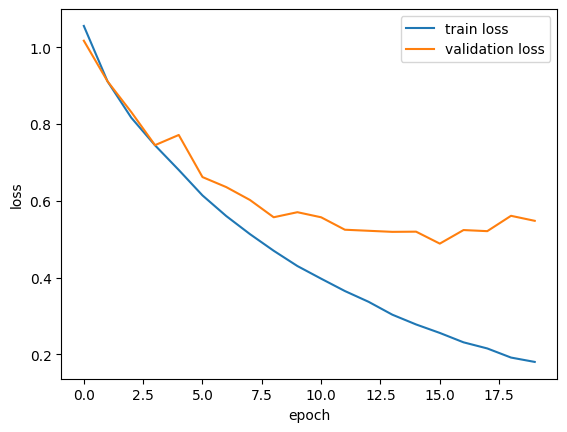

In [ ]:
show_plots(epochs, loss_dic, 'loss')

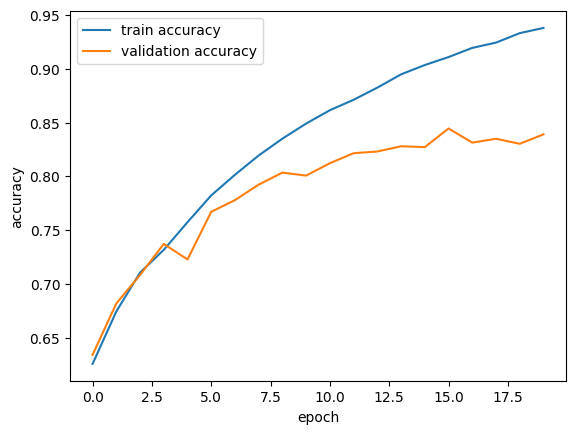

In [ ]:
show_plots(epochs, accuracy_dic, 'accuracy')

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `80%`

In [ ]:
model_path = '/content/drive/MyDrive/AI/Deep Learning/DL/HW2/resnet18.pt'

In [ ]:
model = ResNet18(ResNetBlock, [2, 2, 2, 2])
model.to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
# TODO
test_loss, test_acc = eval_epoch(model.to(device), criterion, testloader, test_mode = True)

print(f'Test Loss: {test_loss:.4f} - ' f'Test Accuracy: {test_acc:.4f}')

Test Loss: 0.5742 - Test Accuracy: 0.8334


## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model

In [ ]:
# TODO
def get_truth_predictions(loader):
    predictions = []

    model.eval()

    # Iterate over data.
    for inputs, labels in testloader:
      inputs = inputs.to(device)
      labels = labels.type(torch.LongTensor).to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward
      with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predictions.extend((preds == labels).cpu())

    return predictions


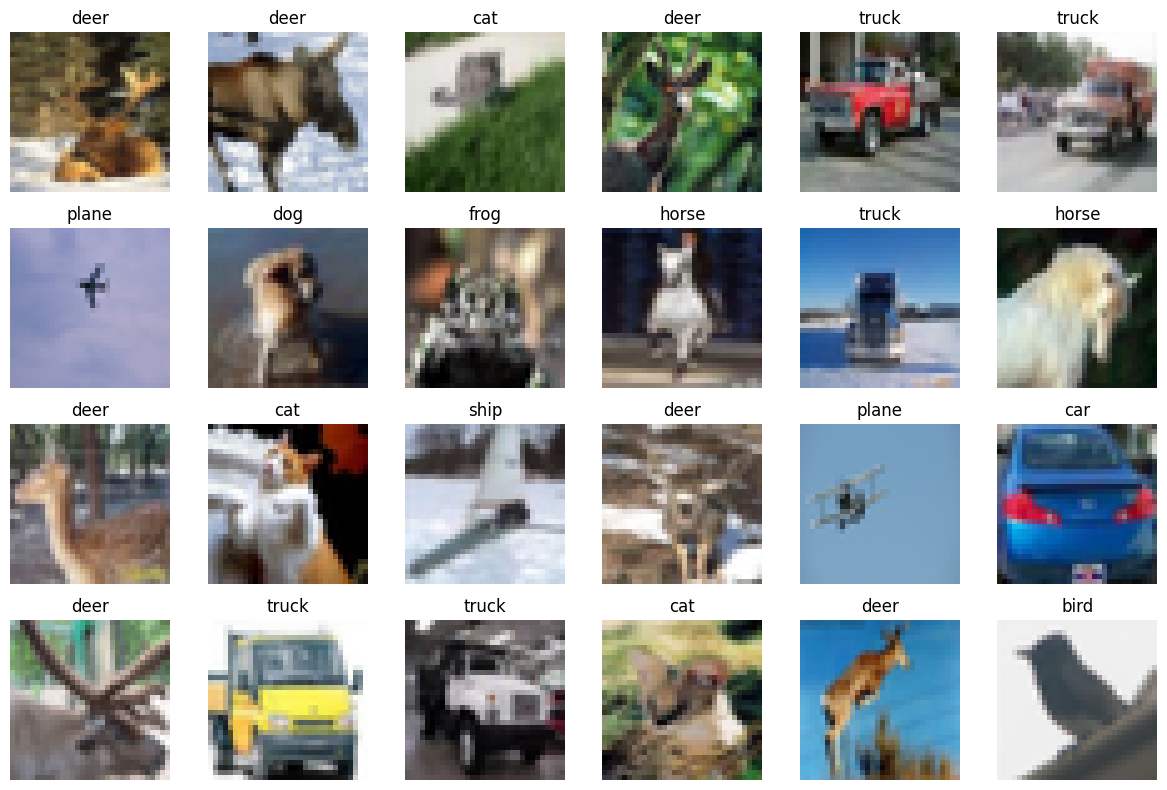

In [ ]:
predictions = get_truth_predictions(testloader)
incorrect_indicies = np.where(np.array(predictions) == False)[0]
indicies = np.random.choice(incorrect_indicies, 24)

fig,axs = plt.subplots(4,6, figsize=(12,8))
idx=0

for i, ax in enumerate(axs.flatten()):
  sample = testset[indicies[idx]]
  ax.imshow(to_pil_image(norminv(sample[0])))
  ax.axis("off")
  ax.title.set_text(classes[sample[1]])
  idx += 1

plt.tight_layout()
plt.show()

## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(50000, N)` saved in a variable (for later usage)

- **Hint 1:** define a tensor with dimension `(50000, N)` where *50000* is the size of the trainset and *N* is the dimension of the feature space

- **Hint 2:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [ ]:
# TODO
initial_trainloader = torch.utils.data.DataLoader(initial_trainset, batch_size=64, shuffle=True)

In [ ]:
embeds = {}
def get_activation(name):
    def hook(model, input, output):
        embeds[name] =  output.detach().squeeze()
    return hook

In [ ]:
model = ResNet18(ResNetBlock, [2, 2, 2, 2])
model.load_state_dict(torch.load(model_path))
model.avgpool.register_forward_hook(get_activation('feature-space'))
model.to(device)

In [ ]:
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names

In [ ]:
return_nodes = {'avgpool': 'feature_space'}
feature_extractor = create_feature_extractor(model, return_nodes=return_nodes)

In [ ]:
def get_feature_spaces(model, dataloader):
  input_tensors = torch.tensor([])
  target_tensors = torch.tensor([])
  feature_spaces = torch.tensor([])

  model.eval()

  # Iterate over data.
  for inputs, labels in dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # forward
    with torch.set_grad_enabled(False):
      outputs = feature_extractor(inputs)
      input_tensors = torch.cat((input_tensors, inputs.cpu()))
      target_tensors = torch.cat((target_tensors, labels.cpu()))
      feature_spaces = torch.cat((feature_spaces, outputs['feature_space'].squeeze().cpu()))

  return input_tensors, target_tensors, feature_spaces

In [ ]:
input_tensors, target_tensors, feature_spaces = get_feature_spaces(model, initial_trainloader)
feature_spaces.shape

torch.Size([50000, 512])

### K Nearest Neighbor in feature space

You already have calculated the feature spaces for trainset ($S$) in the previous section

1. Get 5 random samples from testset which are correctly predicted by the model.
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them


**Hint:** For finding the nearest neighbors in the feature space you can use `torch.linalg.norm` and `torch.topk`

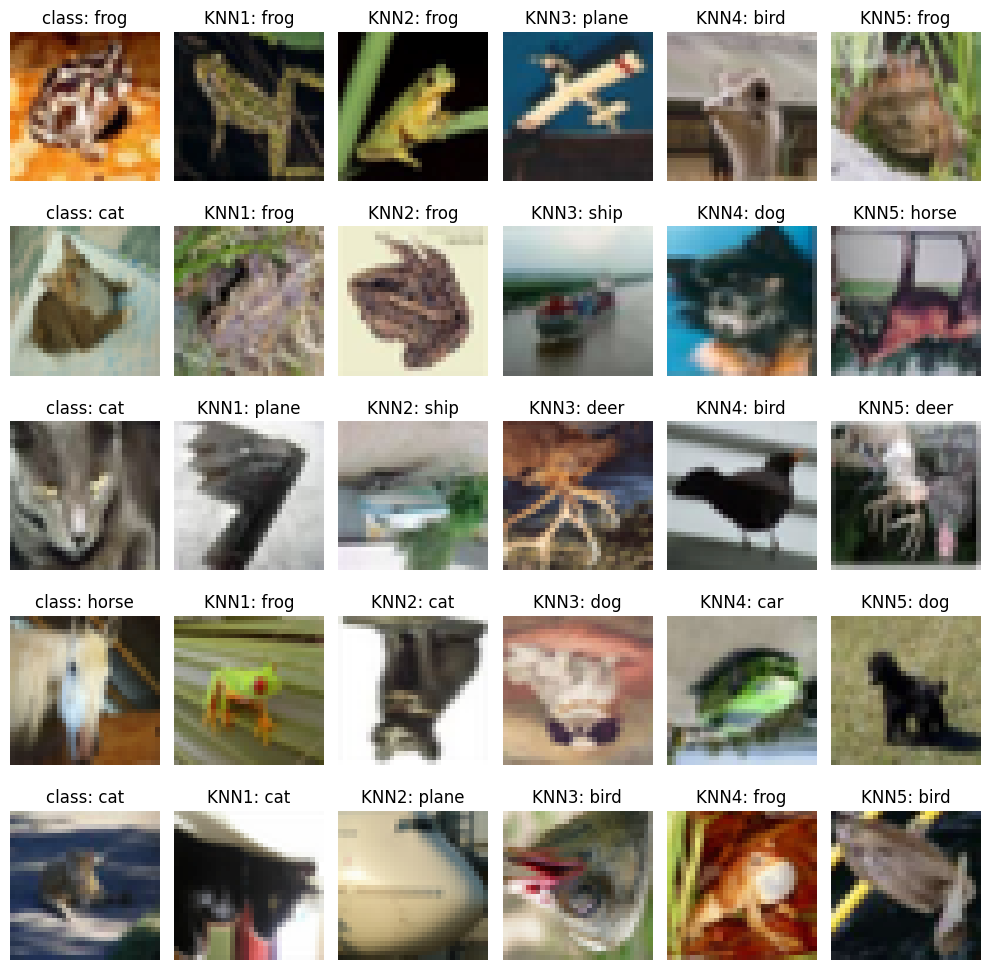

In [ ]:
# TODO
# predictions = get_truth_predictions(testloader)
correct_indicies = np.where(np.array(predictions) == True)[0]
indicies = np.random.choice(incorrect_indicies, 5)

feature_spaces_norm = torch.linalg.norm(feature_spaces, dim=1)

def KNN(input, k=5):
  outputs = feature_extractor(input.unsqueeze(0).to(device))
  sample_feature_space = outputs['feature_space'].squeeze().cpu()

  abs_distance = torch.abs(feature_spaces_norm - torch.linalg.norm(sample_feature_space))
  top5 = torch.topk(abs_distance, k=k, largest=False).indices
  return top5

fig,axs = plt.subplots(5, 6, figsize=(10,10))

for i in range(5):
  sample = testset[indicies[i]]
  knn_indices = KNN(sample[0])

  axs[i, 0].imshow(to_pil_image(norminv(sample[0])))
  axs[i, 0].set_title(f'class: {classes[sample[1]]}')
  axs[i, 0].axis('off')

  for j in range(1, 6):
    axs[i, j].imshow(to_pil_image(norminv(input_tensors[knn_indices[j-1]])))
    axs[i, j].set_title(f'KNN{j}: {classes[int(target_tensors[knn_indices[j-1]])]}')
    axs[i, j].axis('off')

plt.tight_layout()
plt.show()

### TSNE

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections)
2. Now you have a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now you have a vector of size `(M, 2)`)
4. Visualize the points in a 2D plane (Set color of each point based on it's class)

**Hint:** You can use `sklearn.manifold.TSNE`

**Hint:** Use `plt.scatter(x, y, c=labels)`


In [ ]:
# TODO
from sklearn.manifold import TSNE

indices = np.random.randint(len(feature_spaces), size=2000)

samples_feature_space = feature_spaces[indices]
samples_target = target_tensors[indices]

tsne = TSNE(n_components=2, random_state=0)
tsne_data = tsne.fit_transform(samples_feature_space)

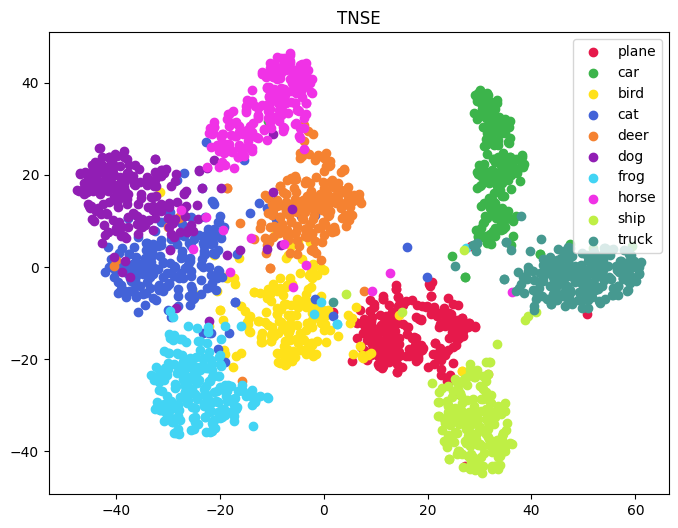

In [ ]:
plt.figure(figsize=(8,6))
plt.title('TNSE')
class_lables = np.arange(10)
colors = ['#e6194B', # red
          '#3cb44b', # green
          '#ffe119', # yellow
          '#4363d8', # blue
          '#f58231', # orange
          '#911eb4', # purple
          '#42d4f4', # cyan
          '#f032e6', # megenta
          '#bfef45', # lime
          '#469990'  # teal
          ]

for class_label, color in zip(class_lables, colors):
    class_indices = np.where(samples_target == class_label)[0]
    plt.scatter(tsne_data[class_indices, 0], tsne_data[class_indices, 1], c=color)

plt.legend(classes)

# CIFAR10 Colorization

In this part of the assignment, we want to do an image colorization task using PyTorch on CIFAR10 dataset. We want to train a model that colors  a black-and-white image.

## Import Libraries

Import needed libraries

In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torchvision
from torchvision.transforms.functional import to_pil_image, pil_to_tensor, rgb_to_grayscale, to_grayscale
import matplotlib.pyplot as plt
import sklearn
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Custom Dataset

Define a custom dataset class by extensing `torch.utils.data.Dataset`

**Notice:** your dataset should output two things: black-and-white image and the RGB image

**Hint:** You don't have to reinvent the wheel. Your class should just be a wrapper for CIFAR10 dataset

In [3]:
class BlackAndWhiteCIFAR10(Dataset):
    """
    Define a custom dataset class by extending `torch.utils.data.Dataset`
    this class is a dataset for the CIFAR10 data in pytorch and it has the black and white image of the original CIFAR10 image as the data
    and the original RGB image as the target
    this class is just a wrapper for the torchvision.datasets.CIFAR10 class
    """

    def __init__(self, train=True, root='./data', download=True, transform=None):
        self.dataset_rgb = torchvision.datasets.CIFAR10(root=root, train=train, download=download, transform=transform)

    def __len__(self):
        return len(self.dataset_rgb)

    def __getitem__(self, index):
        tensor_rgb = self.dataset_rgb[index][0]

        tensor_gray = rgb_to_grayscale(tensor_rgb, num_output_channels=1)

        return tensor_gray, tensor_rgb


## Transforms & Dataset & Dataloader

**Notice:** Use your defined custom dataset class for defining the datasets

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.20, 0.20, 0.20)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.20, 0.20, 0.20)),
])

In [6]:
initial_trainset = BlackAndWhiteCIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

100%|██████████| 170498071/170498071 [00:13<00:00, 12694167.62it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [7]:
trainset, valset = random_split(initial_trainset, [0.8, 0.2])

In [40]:
trainloader = DataLoader(trainset, batch_size=256, shuffle=True)
valloader = DataLoader(valset, batch_size=256, shuffle=False)

## Dataset Visualization

Visualize your dataset (black-and-white image along with the RGB image) by sampling from your trainset

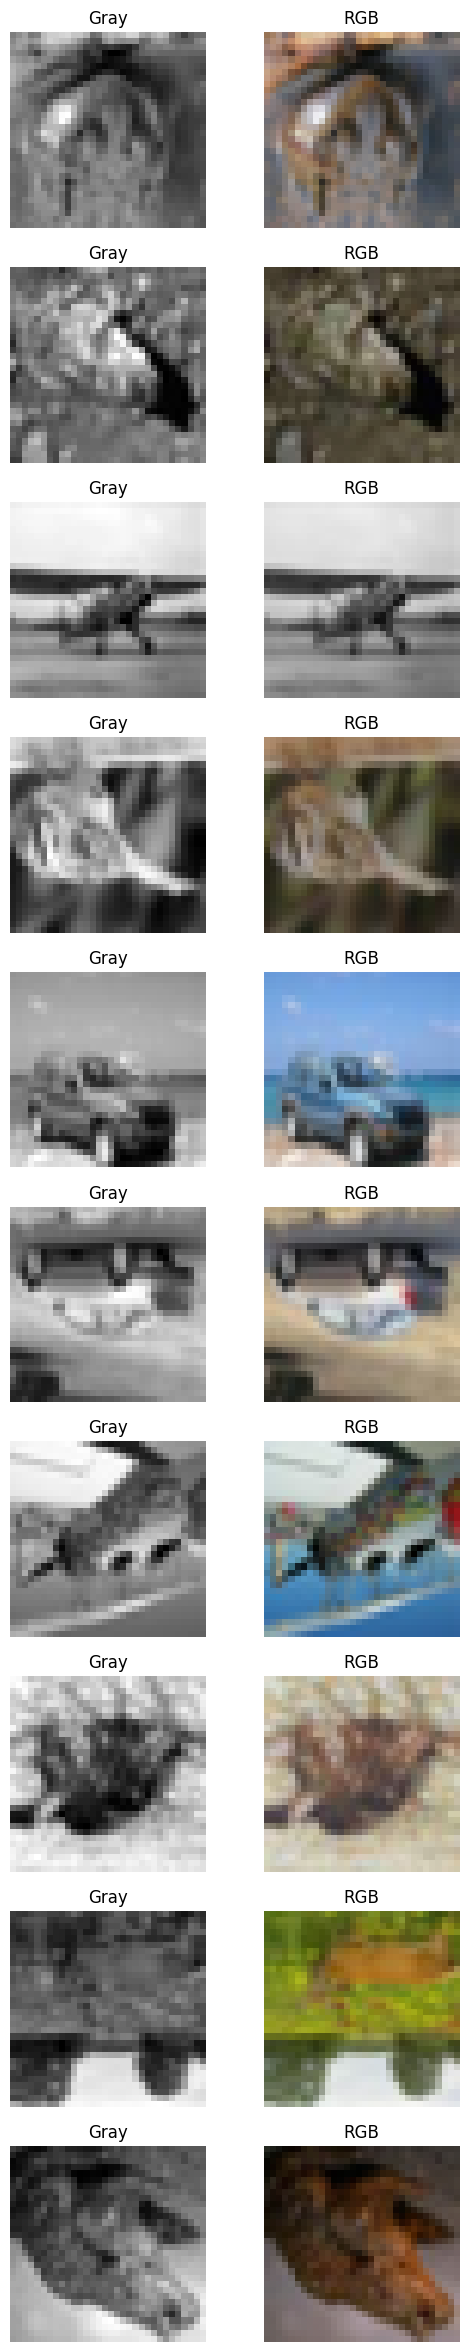

In [16]:
# TODO
k = 10
fig,axs = plt.subplots(k, 2, figsize=(6,30))
idxs = np.random.randint(0, len(trainset), size=k)
for i, idx in enumerate(idxs):
    sample = trainset[idx]
    axs[i][0].title.set_text('Gray')
    axs[i][0].imshow(to_pil_image(norminv(sample[0])), cmap='gray')
    axs[i][0].axis('off')

    axs[i][1].title.set_text('RGB')
    axs[i][1].imshow(to_pil_image(norminv(sample[1])))
    axs[i][1].axis('off')

## Model

Define your model here (Input: black-and-white image, Output: RGB image)

**Hint:** You can implement an autoencoder that does the colorization task for you. UNet could be a viable option

In [36]:
from os import pipe2
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        layers = [
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        out = self.block(x)
        return out

class TransConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransConvBlock, self).__init__()

        layers = [
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]

        self.block = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        out = self.block(x)
        out = torch.cat((skip_input, out), dim=1)
        return out


class colorizationNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=3):
      super(colorizationNet, self).__init__()


      self.conv1 = ConvBlock(in_channels, 64)
      self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

      self.conv2 = ConvBlock(64, 128)
      self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

      self.conv3 = ConvBlock(128, 256)
      self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

      self.conv4 = ConvBlock(256, 512)
      self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

      self.conv5 = ConvBlock(512, 1024)

      self.transConv4 = TransConvBlock(1024, 512)
      self.upConv4 = ConvBlock(1024, 512)

      self.transConv3 = TransConvBlock(512, 256)
      self.upConv3 = ConvBlock(512, 256)

      self.transConv2 = TransConvBlock(256, 128)
      self.upConv2 = ConvBlock(256, 128)

      self.transConv1 = TransConvBlock(128,64)
      self.upConv1 = ConvBlock(128, 64)

      self.final = nn.Conv2d(64, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
      # encoder
      e1 = self.conv1(x)
      p1 = self.maxpool1(e1)
      e2 = self.conv2(p1)
      p2 = self.maxpool2(e2)
      e3 = self.conv3(p2)
      p3 = self.maxpool3(e3)
      e4 = self.conv4(p3)
      p4 = self.maxpool4(e4)

      # bottleneck
      b = self.conv5(p4)

      # decoder
      d4 = self.transConv4(b, e4)
      d4 = self.upConv4(d4)
      d3 = self.transConv3(d4, e3)
      d3 = self.upConv3(d3)
      d2 = self.transConv2(d3, e2)
      d2 = self.upConv2(d2)
      d1 = self.transConv1(d2, e1)
      d1 = self.upConv1(d1)

      # final
      out = self.final(d1)

      return out


## Train

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Validation loss
- [ ] save train/validation loss (of each epoch) in an array for later usage

In [ ]:
net = colorizationNet()
net.to(device)

In [43]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [21]:
import tqdm
from time import time

In [22]:
def train_epoch(net: torch.nn.Module, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer ,dataloader: torch.utils.data.DataLoader):
    net.train() # Set model to training mode

    running_loss = 0.0
    # running_corrects = 0.0

    # Iterate over data.
    for inputs, labels in dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward
      with torch.set_grad_enabled(True):
        outputs = net(inputs)
        loss = criterion(outputs, labels)


        loss.backward()
        optimizer.step()

      # statistics
      running_loss += loss.item()

    loss = running_loss / len(dataloader)

    return loss

def eval_epoch(net: torch.nn.Module, criterion: torch.nn.Module, dataloader: torch.utils.data.DataLoader, test_mode: bool = False):
    net.eval() # Set model to eval mode

    running_loss = 0.0
    # running_corrects = 0.0

    # Iterate over data.
    for inputs, labels in dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward
      with torch.set_grad_enabled(False):
        outputs = net(inputs)
        loss = criterion(outputs, labels)

      # statistics
      running_loss += loss.item()

    loss = running_loss / len(dataloader)

    return loss

In [45]:
epochs = 40
model_path = '/content/drive/MyDrive/AI/Deep Learning/DL/HW2/colorizationNet.pt'

best_val_loss = float('inf')

accuracy_dic, loss_dic = {}, {}
loss_dic['train'], loss_dic['val'] = [], []

for e in range(epochs):
    train_loss = train_epoch(net, criterion, optimizer, trainloader)
    val_loss = eval_epoch(net, criterion, valloader)

    loss_dic['train'].append(train_loss)
    loss_dic['val'].append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # best_model = model.state_dict()
        torch.save(net.state_dict(), model_path)

    print(f'Epoch [{e+1}/{epochs}] - '
            f'Train Loss: {train_loss:.4f} - '
            f'Validation Loss: {val_loss:.4f}')

Epoch [1/20] - Train Loss: 0.1169 - Validation Loss: 0.1205
Epoch [2/20] - Train Loss: 0.1159 - Validation Loss: 0.1183
Epoch [3/20] - Train Loss: 0.1152 - Validation Loss: 0.1169
Epoch [4/20] - Train Loss: 0.1138 - Validation Loss: 0.1233
Epoch [5/20] - Train Loss: 0.1126 - Validation Loss: 0.1226
Epoch [6/20] - Train Loss: 0.1123 - Validation Loss: 0.1220
Epoch [7/20] - Train Loss: 0.1109 - Validation Loss: 0.1189
Epoch [8/20] - Train Loss: 0.1102 - Validation Loss: 0.1208
Epoch [9/20] - Train Loss: 0.1090 - Validation Loss: 0.1216
Epoch [10/20] - Train Loss: 0.1084 - Validation Loss: 0.1182
Epoch [11/20] - Train Loss: 0.1071 - Validation Loss: 0.1241
Epoch [12/20] - Train Loss: 0.1058 - Validation Loss: 0.1200
Epoch [13/20] - Train Loss: 0.1047 - Validation Loss: 0.1231
Epoch [14/20] - Train Loss: 0.1031 - Validation Loss: 0.1201
Epoch [15/20] - Train Loss: 0.1023 - Validation Loss: 0.1207
Epoch [16/20] - Train Loss: 0.1011 - Validation Loss: 0.1183
Epoch [17/20] - Train Loss: 0.100

### Visualize Loss plot

Using the arrays that you have (from task 2 in the above section), visualize the loss plot (train and validation together)

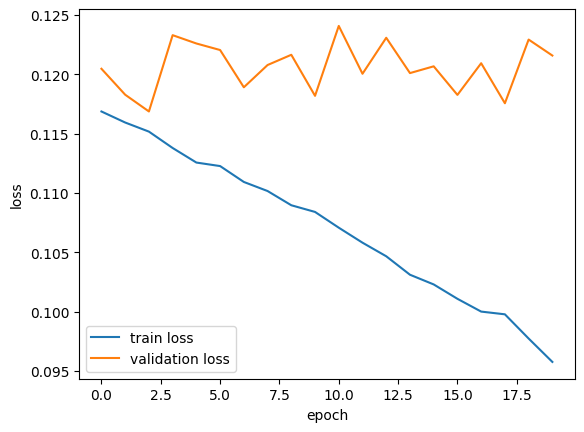

In [46]:
# TODO
show_plots(epochs, loss_dic, 'loss')

## Evaluation

1. Sample 36 random samples from testset (your own dataset class)
2. Give each of the 36 samples to your trained model and get the outputs
3. Visualize `input` (black-and-white image), `output` (output of the model with the given black-and-white input image) and `ground truth` (the actual RGB image)



In [ ]:
model = colorizationNet()
model_path = '/content/drive/MyDrive/AI/Deep Learning/DL/HW2/colorizationNet.pt'
model.load_state_dict(torch.load(model_path))
model.to(device)

In [48]:
testset = BlackAndWhiteCIFAR10(root='./data', train=False,
                                download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

Files already downloaded and verified


In [70]:
# TODO
test_loss = eval_epoch(model, criterion, testloader, test_mode=True)
test_loss

0.11638449744623937

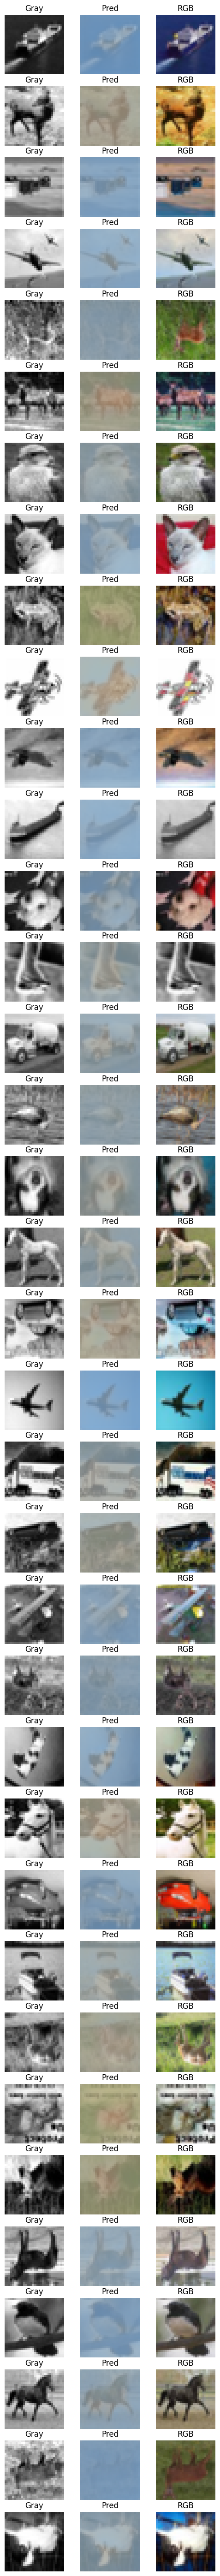

In [71]:
# TODO
k = 36
fig,axs = plt.subplots(36, 3, figsize=(6,72))
idxs = np.random.randint(0, len(testset), size=k)

for i, idx in enumerate(idxs):
    sample = trainset[idx]
    axs[i][0].title.set_text('Gray')
    axs[i][0].imshow(to_pil_image(norminv(sample[0])), cmap='gray')
    axs[i][0].axis('off')

    axs[i][1].title.set_text('Pred')
    pred = model(sample[0].unsqueeze(0).to(device))[0].cpu().detach()
    axs[i][1].imshow(to_pil_image(norminv(pred)))
    axs[i][1].axis('off')

    axs[i][2].title.set_text('RGB')
    axs[i][2].imshow(to_pil_image(norminv(sample[1])))
    axs[i][2].axis('off')

# References

- [Torchvision](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L60)

- [stackoverflow](https://stackoverflow.com/questions/63552044/how-to-extract-feature-vector-from-single-image-in-pytorch)

- [medium](https://medium.com/@rabiagondur/feature-extraction-using-cnns-via-pytorch-ed79da32c950)
